## ==== Install and import modules ====

In [1]:
# Run this the first time you load this notebook
# Once it finishe running, go to Runtime > Restart Runtime
# Once Runtime restarts, continue running cells in order (including this one)
import shutil
if not shutil.which("arviz"):
    !pip install -q --upgrade arviz
if not shutil.which("pymc3"):
    !pip install -q --upgrade pymc3

     |████████████████████████████████| 1.6MB 7.6MB/s 
     |████████████████████████████████| 768kB 30.5MB/s 
     |████████████████████████████████| 870kB 7.8MB/s 
     |████████████████████████████████| 1.8MB 22.9MB/s 


In [2]:
import pymc3 as pm
from scipy.stats import linregress
import numpy as np
import pylab as plt
from joblib import cpu_count

import warnings
warnings.filterwarnings('ignore')

## ==== Generate Data ====

In [3]:
size = 20
true_intercept = 1
true_slope = 2

x  = np.linspace(0.5, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.1, size=size)

## ==== Perform OLS regression and plot line ===

In [4]:
res = linregress(x, y)

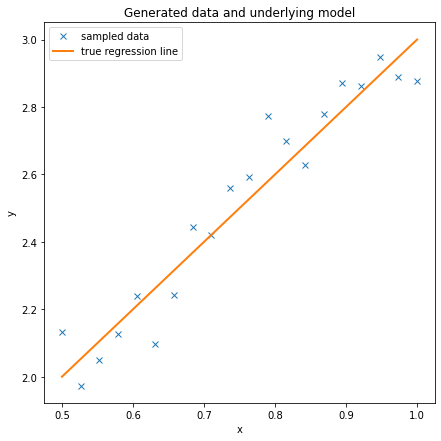

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## ==== Construct and fit Bayesian Linear Regression Model ====

In [22]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors

    # Explicitly modelling the noise in the data as  varaible "sigma"
    # Cauchy distribution has fatter tails than Normal disrtibution. Makes it more resilient to outlier
    # Half-Cauchy is the positive part...can't have noise with negative amplitude
    # Beta parameter is analogoous to sigma for Normal distribution. 
    # Large beta means we're assuming little information about the variable 
    sigma = pm.HalfCauchy("Noise", beta=10, testval=1.0)
    
    # Model intercept and slope variables as a wide normal distributions (assuming little information)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # a data container, technical feature of the language
    # we will use this later to swap out the data
    x_ = pm.Data('features', x) 

    # Define likelihood (how well the model fits the data)
    # Model the data as Normally distributed about the linear model with "sigma" noise
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x_, sigma=sigma, observed=y)
    #likelihood = pm.Normal("y", mu=intercept + x_coeff * x_, observed=y)

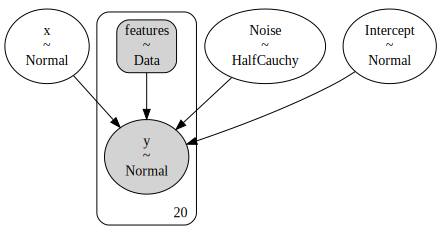

In [23]:
# Plot the graph for the model
pm.model_to_graphviz(model)

In [24]:
# Use MCMC sampling to draw samples from the joint distribuion of the model
with model:
    # Inference!
    trace = pm.sample(3000, cores=cpu_count())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, Noise]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 20 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


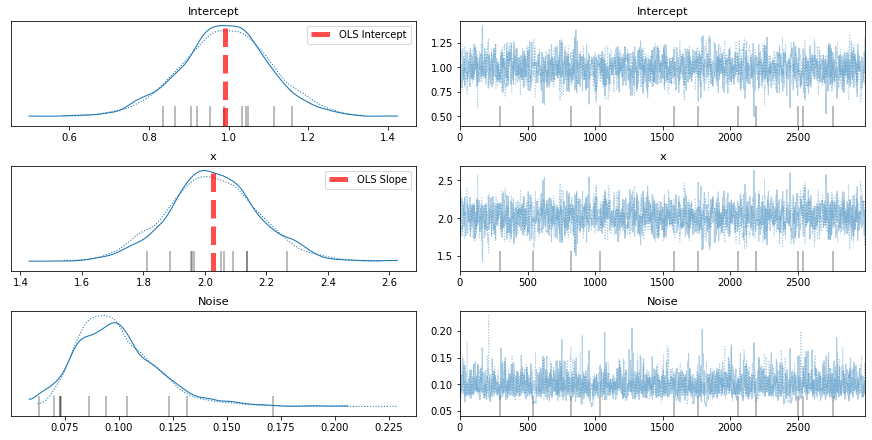

In [25]:
# Plot samples from the MCMC trace and compare to OLS fit paramters
ax = pm.traceplot(trace);
ax[0,0].axvline(res.intercept, linestyle = '--', c = 'red', lw = 5, alpha = 0.7, label = 'OLS Intercept')
ax[1,0].axvline(res.slope, linestyle = '--', c = 'red', lw = 5, alpha = 0.7, label = 'OLS Slope')
ax[0,0].legend()
ax[1,0].legend()

In [26]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
with model:
  ppc = pm.sample_posterior_predictive(trace, 1000)
mean_ppc, std_ppc = np.mean(ppc['y'],axis=0),np.std(ppc['y'],axis=0)

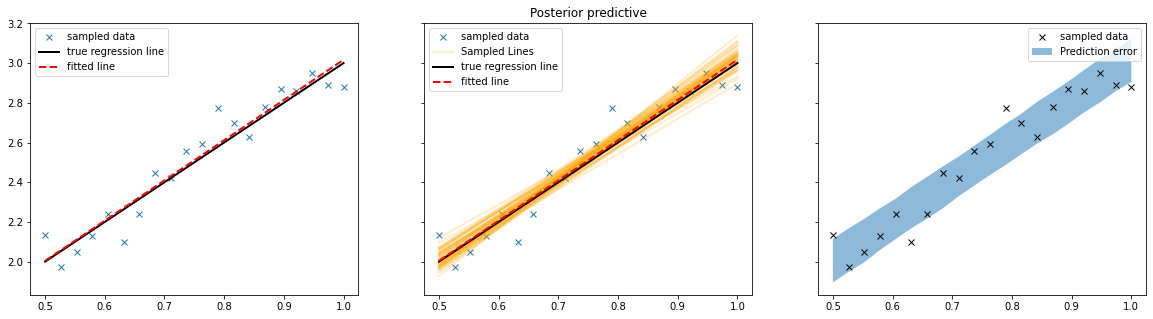

In [27]:
# Plots to compare Bayesian Model output to actual data and OLS regression model
fig, (ax0, ax1,ax2) = plt.subplots(1,3, sharey=True, figsize = (20,5))  

ax0.plot(x, y, "x", label="sampled data")
ax0.plot(x, true_regression_line, label="true regression line", lw=2, c = 'k')
ax0.plot(x, res.intercept + res.slope*x,'--', c ='r', label='fitted line', lw = 2)
ax0.legend()

plt.sca(ax1)
ax1.plot(x, y, "x", label="sampled data")
pm.plot_posterior_predictive_glm(trace, x, samples=50,alpha=0.2, color = 'orange', linewidth = 2, label = 'Sampled Lines')
ax1.plot(x, true_regression_line, label="true regression line", lw=2, c = 'k')
ax1.plot(x, res.intercept + res.slope*x, '--', c ='r', label='fitted line', lw = 2)
plt.legend()

ax2.plot(x, y, "x", label="sampled data", c='k')
ax2.fill_between(x, mean_ppc+std_ppc, mean_ppc-std_ppc, alpha = 0.5, label = 'Prediction error')
ax2.legend()

## ==== Dramatic demonstration of prediction error ====

In [20]:
# Create new range of values for preduction using the fitted model
x_new = np.linspace(-10, 10, 50)
with model:
    # Swap out old data for new data and sample predictions
    pm.set_data({'features': x_new})
    new_ppc = pm.sample_posterior_predictive(trace)

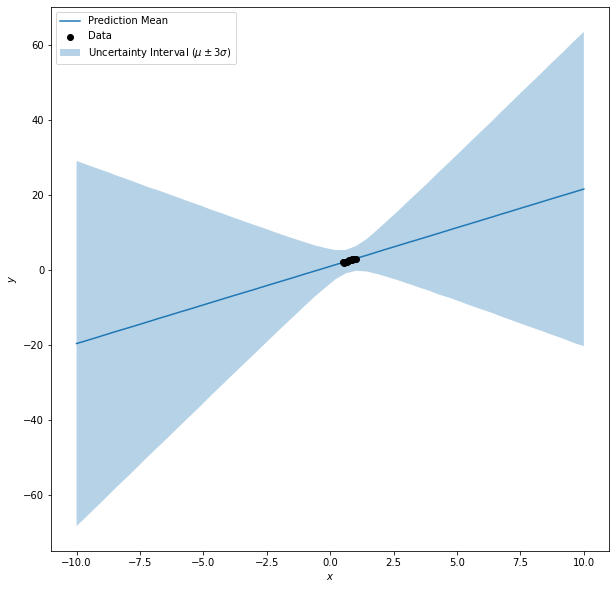

In [21]:
# Plot prediction uncertainty range

# Extract new predictions and calculate mean and std
y_pred = new_ppc['y']
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

# Plot data with prediction uncertainty
plt.figure(figsize=(10,10))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')